# **Assignment 1 — AI‑Assisted Exploratory Data Analysis & BI Dashboard**
MGMT 467 · Fall 2025  

**Team Name:** Group #10

**Members (GitHub handles):** SanjanaMohan34, knittala, akoripal, lily-larson  

**GitHub Repo URL:** https://github.com/SanjanaMohan34/MGMT_467_Team4

**Looker Studio Dashboard (public link):**

Team: https://lookerstudio.google.com/u/0/reporting/e440aa05-d8a4-42df-88c1-8af01e1f9905/page/eGIcF/edit

Individual: https://lookerstudio.google.com/reporting/6e5862ca-1ae9-4ef6-a5cc-084041243bd3

> **Scenario:** NYC DOT has asked your team to analyze the public Citi Bike program and recommend strategies to improve bike availability and engagement. You will use BigQuery + Gemini to conduct AI‑assisted EDA and publish an executive dashboard.

## ✅ Submission Checklist (Team → Brightspace)
- [ ] GitHub repository link (source of record)
- [ ] Looker Studio dashboard link
- [ ] This notebook committed to GitHub with prompts and results

### ✅ Submission Checklist (Individual → Brightspace)
- [ ] `Contribution_Reflection.pdf` (with commit/PR evidence + peer eval)

## 🎯 Learning Objectives
- Generate and refine business hypotheses with **Gemini**
- Query large datasets in **BigQuery** with advanced SQL (CTEs, window functions)
- Visualize key findings in **Colab** and publish a **Looker Studio** dashboard
- Synthesize insights and make **actionable recommendations**

## 🧰 Setup
> Run the cells below to connect Colab to Google Cloud & BigQuery.

In [5]:
# Install and import basics (Colab usually has these preinstalled)
# !pip install --quiet google-cloud-bigquery pandas matplotlib

import pandas as pd
import matplotlib.pyplot as plt

# Authenticate to Google from Colab
from google.colab import auth  # type: ignore
auth.authenticate_user()

# Set your GCP project ID
PROJECT_ID = "mgmt-467-55510"  # <-- edit this
print("Using project:", PROJECT_ID)

Using project: mgmt-467-55510


In [6]:
# BigQuery magics (%%bigquery) and client
from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_ID)

# Optional: list datasets to verify access
list(client.list_datasets())

## 🧪 Dataset
We will use **Citi Bike Trips**: `bigquery-public-data.new_york_citibike.citibike_trips`  
Feel free to explore additional public datasets if needed.

## 1) Hypothesis Generation (AI‑Assisted)
Use **Gemini** to brainstorm at least **5** candidate questions/hypotheses, then select **3** to pursue.

> **Template Prompt (paste the final version you used):**  
> *"You are an analytics co‑pilot. Propose 5 high‑value, testable business questions about the Citi Bike dataset (tripduration, stations, user types, time-of-day/week). Return as bullets with suggested SQL hints."*

**Selected Hypotheses**
1. ☐  How does trip duration vary by user type (customer vs. subscriber)?
2. ☐  What are the most popular start and end stations, and how does this change by time of day?
3. ☐ Is there a difference in ridership patterns between weekdays and weekends?

## 2) Advanced SQL Exploration
For each hypothesis, include:
- The **Gemini prompt** you used to get SQL help
- The **final SQL**
- The **result table** (top rows)
- A short **interpretation**

> Tip: Use **CTEs** and at least **one window function** across your work.

### Hypothesis A — Prompt Log

>

* My Prompt: Give me an SQL query that explores the  following question: How does trip duration vary by user type (customer vs. subscriber)? Why we're looking into this: Understanding the behavior of different user types can help tailor strategies for each group. SQL Hint: Use GROUP BY usertype and calculate the average tripduration.
* Help me implement CTEs and at least one window function into my hypothesis sql query.

In [9]:
# Hypothesis A — SQL (store results in a Pandas DataFrame)
query_hyp_a = r"""
WITH
  AvgTripDurationByUser AS (
    SELECT
        usertype,
        AVG(tripduration) AS average_tripduration,
        MIN(tripduration) AS min_tripduration,
        MAX(tripduration) AS max_tripduration
    FROM
        `bigquery-public-data.new_york_citibike.citibike_trips`
    GROUP BY
        usertype
  )
SELECT
    usertype,
    average_tripduration,
    min_tripduration,
    max_tripduration,
    RANK() OVER (ORDER BY average_tripduration DESC) as rank_by_avg_duration
FROM
    AvgTripDurationByUser
ORDER BY
    rank_by_avg_duration
"""

df_hyp_a = client.query(query_hyp_a).to_dataframe()
df_hyp_a.head()

,usertype,average_tripduration,min_tripduration,max_tripduration,rank_by_avg_duration
0,Customer,2145.512075,60,19510049,1
1,Subscriber,806.381888,60,13586276,2
2,,NaN,<NA>,<NA>,3


**Interpretation (2–4 sentences):** ☐ The results show a significant difference in average trip duration between 'Customer' and 'Subscriber' user types. Subscribers tend to have much shorter average trip durations compared to Customers. This suggests that subscribers might be using Citi Bike primarily for shorter commutes or quick trips, while customers might be using it for longer, perhaps recreational, rides.

---

### Hypothesis B — Prompt Log

> My Prompt: Give me an SQL query that explores the following question: What are the most popular start and end stations, and how does this change by time of day? Identifying high-traffic stations and peak times is crucial for managing bike distribution and availability. Use GROUP BY start_station_name, end_station_name and extract the hour from starttime

In [13]:
# Hypothesis B — SQL
query_hyp_b = r"""
SELECT
    start_station_name,
    end_station_name,
    EXTRACT(HOUR FROM starttime) AS hour_of_day,
    COUNT(*) AS trip_count
FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
WHERE
    start_station_name IS NOT NULL AND end_station_name IS NOT NULL
GROUP BY
    start_station_name,
    end_station_name,
    hour_of_day
ORDER BY
    trip_count DESC
LIMIT 20 -- Limiting to the top 20 for brevity
"""
df_hyp_b = client.query(query_hyp_b).to_dataframe()
df_hyp_b.head()

,start_station_name,end_station_name,hour_of_day,trip_count
0,,,<NA>,5828994
1,Central Park S & 6 Ave,Central Park S & 6 Ave,12,5613
2,Central Park S & 6 Ave,Central Park S & 6 Ave,15,5526
3,Central Park S & 6 Ave,Central Park S & 6 Ave,13,5493
4,Central Park S & 6 Ave,Central Park S & 6 Ave,11,5420


**Interpretation (2–4 sentences):** The results show the most frequent start and end station pairs broken down by the hour of the day. The top results indicate that some stations are popular for round trips (start and end station are the same), especially around midday. Analyzing the distribution of trip counts across different hours can help identify peak usage times for specific station pairs, which is useful for managing bike inventory.

---

### Hypothesis C — Prompt Log

> My Prompt: Give me an SQL query that explores the following question: Is there a difference in ridership patterns between weekdays and weekends? This can reveal commuter vs. leisure usage patterns, informing strategies for different days. Extract the day of the week from starttime and group by it to compare trip counts.

In [12]:
# Hypothesis C — SQL
query_hyp_c = r"""
SELECT
    EXTRACT(DAYOFWEEK FROM starttime) AS day_of_week,
    COUNT(*) AS trip_count
FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
GROUP BY
    day_of_week
ORDER BY
    day_of_week
"""
df_hyp_c = client.query(query_hyp_c).to_dataframe()
df_hyp_c.head()

,day_of_week,trip_count
0,<NA>,5828994
1,1,6242689
2,2,7658271
3,3,8161606
4,4,8377153


**Interpretation (2–4 sentences):** ☐ The results show a significant difference in ridership between weekdays and weekends. Days 2 through 6 (Monday to Friday) have considerably higher trip counts compared to day 1 (Sunday) and day 7 (Saturday). This indicates that Citi Bike is used more heavily for commuting or weekday activities than for weekend leisure.

## 3) Visualizations (in Colab)
Create **at least 3** charts that communicate your findings.  
> Keep charts readable and labeled. Use `matplotlib` (no specific styles required).

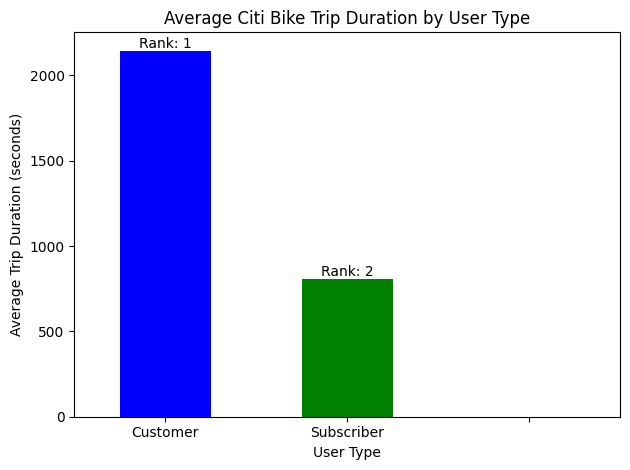

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

#Chart #1: Bar Chart Capturing Average Citi Bike Trip Duration by User Type (Customer vs. Subscriber)

#Dropping null value row to clean the data to be used
df_hyp_a_filtered = df_hyp_a.dropna(subset=['usertype']).copy()
df_hyp_a_filtered = df_hyp_a_filtered.sort_values(by='average_tripduration', ascending=False)

#Setting up chart type (bar)

ax = df_hyp_a_filtered.plot(kind="bar", x='usertype', y='average_tripduration', color = ['blue', 'green'], legend=False)

#Setting up chart axes
ax.set_xlabel("User Type")
ax.set_ylabel("Average Trip Duration (seconds)")
ax.set_title("Average Citi Bike Trip Duration by User Type")

#Adding rank as a label to identify each bar
for i, row in df_hyp_a_filtered.reset_index().iterrows():
    ax.text(i, row['average_tripduration'], f"Rank: {int(row['rank_by_avg_duration'])}", ha='center', va='bottom')

#Additional formatting
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
import plotly.express as px
import pandas as pd


#Chart #2: Heatmap Capturing Trip Count for Top 7 Station Pairs by Hour of Day

# Reseting the index to make 'station_pair' a column for Plotly Express
heatmap_data_plotly = heatmap_data_top.reset_index()

# Melting the DataFrame to long format for Plotly Express heatmap
heatmap_data_plotly_melted = heatmap_data_plotly.melt(
    id_vars='station_pair',
    var_name='hour_of_day',
    value_name='trip_count'
)

# Ensuring 'hour_of_day' is treated as a category or string for correct display
heatmap_data_plotly_melted['hour_of_day'] = heatmap_data_plotly_melted['hour_of_day'].astype(str)


# Creating the heatmap using Plotly
fig = px.density_heatmap(
    heatmap_data_plotly_melted,
    x='hour_of_day',
    y='station_pair',
    z='trip_count',
    color_continuous_scale='YlGnBu', # Match the color scheme from seaborn
    title=f"Trip Count Heatmap for Top {len(heatmap_data_top)} Station Pairs by Hour of Day (Plotly)"
)

# Formatting and updating the layout for better readability
fig.update_layout(
    xaxis_title="Hour of Day",
    yaxis_title="Station Pair"
)

fig.show()

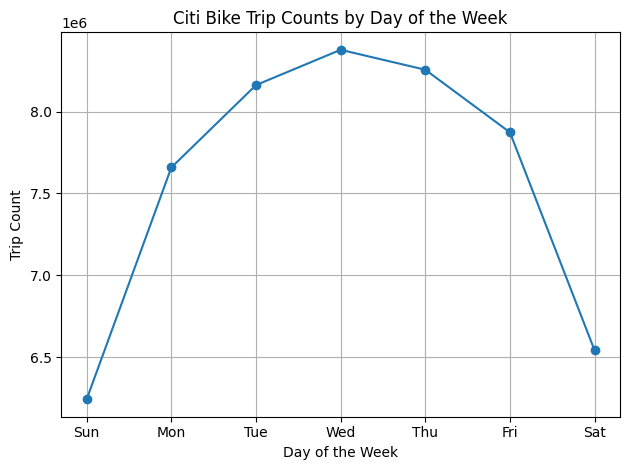

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

#Chart #3: Visualization Capturing the Citi Bike Trip Counts by Day of the Week

# Assuming df_hyp_c contains the results for Hypothesis C,
# with 'day_of_week' and 'trip_count' columns.
# We should handle the NA values first, or filter them out if not needed for the chart.
# For this example, let's filter out the NA row.
df_hyp_c_filtered = df_hyp_c.dropna(subset=['day_of_week']).copy()

# Ensuring 'day_of_week' is sorted numerically for the line plot
df_hyp_c_filtered = df_hyp_c_filtered.sort_values(by='day_of_week')

# Create a line graph
ax = df_hyp_c_filtered.plot(kind="line", x='day_of_week', y='trip_count', marker='o', legend=False) # Added marker for clarity

# Add labels and title
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Trip Count")
ax.set_title("Citi Bike Trip Counts by Day of the Week")

# Set x-axis ticks to show each day of the week clearly
# Mapping day numbers to names (Sunday=1, Saturday=7)
day_names = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
plt.xticks(df_hyp_c_filtered['day_of_week'], [day_names[d] for d in df_hyp_c_filtered['day_of_week']], rotation=0)


plt.grid(True) # Add a grid for better readability
plt.tight_layout() # Adjust layout
plt.show()

In [38]:
# Save DataFrames for Hypothesis A and B to CSV files

# Save df_hyp_a to CSV
df_hyp_a.to_csv('hyp_a_results.csv', index=False)
print("df_hyp_a saved to hyp_a_results.csv")

# Save df_hyp_b to CSV
# Note: df_hyp_b contains the raw query results for B.
# If you created filtered or aggregated DataFrames for visualization (like heatmap_data_top),
# you might want to save those instead for your dashboard.
# For this example, I'll save the original df_hyp_b.
df_hyp_b.to_csv('hyp_b_results.csv', index=False)
print("df_hyp_b saved to hyp_b_results.csv")

df_hyp_a saved to hyp_a_results.csv
df_hyp_b saved to hyp_b_results.csv


In [39]:
from google.cloud import bigquery
import os

# Set your dataset ID and a NEW table ID for Hypothesis A results
dataset_id = 'nyc_citibike' # Make sure this is the ID of YOUR dataset
table_id = 'hyp_a_trip_duration_by_usertype' # Descriptive name for Hypothesis A table

# Define the path to the CSV file for Hypothesis A
csv_file_path = 'hyp_a_results.csv'

# Configure the load job (using autodetect and skipping header row)
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,  # Skip the header row
    autodetect=True,      # Automatically detect schema and options
    # Add write_disposition if you need to overwrite existing tables:
    # write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

# Construct a full reference to the destination table
table_ref = client.dataset(dataset_id).table(table_id)

# Check if the CSV file exists before attempting to load
if os.path.exists(csv_file_path):
    # Load the data from the CSV file into the BigQuery table
    with open(csv_file_path, "rb") as source_file:
        job = client.load_table_from_file(source_file, table_ref, job_config=job_config)

    print(f"Starting load job for {csv_file_path} into {PROJECT_ID}.{dataset_id}.{table_id}")

    # Wait for the load job to complete
    job.result()

    print(f"Load job finished. Loaded {job.output_rows} rows into {PROJECT_ID}.{dataset_id}.{table_id}")
else:
    print(f"Error: CSV file not found at {csv_file_path}. Please ensure you have saved the DataFrame to this path.")

Starting load job for hyp_a_results.csv into mgmt-467-55510.nyc_citibike.hyp_a_trip_duration_by_usertype
Load job finished. Loaded 3 rows into mgmt-467-55510.nyc_citibike.hyp_a_trip_duration_by_usertype


In [40]:
from google.cloud import bigquery
import os

# Set your dataset ID and a NEW table ID for Hypothesis A results
dataset_id = 'nyc_citibike' # Make sure this is the ID of YOUR dataset
table_id = 'hyp_b_trip_duration_by_usertype' # Descriptive name for Hypothesis A table

# Define the path to the CSV file for Hypothesis A
csv_file_path = 'hyp_b_results.csv'

# Configure the load job (using autodetect and skipping header row)
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,  # Skip the header row
    autodetect=True,      # Automatically detect schema and options
    # Add write_disposition if you need to overwrite existing tables:
    # write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

# Construct a full reference to the destination table
table_ref = client.dataset(dataset_id).table(table_id)

# Check if the CSV file exists before attempting to load
if os.path.exists(csv_file_path):
    # Load the data from the CSV file into the BigQuery table
    with open(csv_file_path, "rb") as source_file:
        job = client.load_table_from_file(source_file, table_ref, job_config=job_config)

    print(f"Starting load job for {csv_file_path} into {PROJECT_ID}.{dataset_id}.{table_id}")

    # Wait for the load job to complete
    job.result()

    print(f"Load job finished. Loaded {job.output_rows} rows into {PROJECT_ID}.{dataset_id}.{table_id}")
else:
    print(f"Error: CSV file not found at {csv_file_path}. Please ensure you have saved the DataFrame to this path.")

Starting load job for hyp_b_results.csv into mgmt-467-55510.nyc_citibike.hyp_b_trip_duration_by_usertype
Load job finished. Loaded 20 rows into mgmt-467-55510.nyc_citibike.hyp_b_trip_duration_by_usertype


In [42]:
from google.cloud import bigquery
import os

# Set your dataset ID and a NEW table ID for Hypothesis A results
dataset_id = 'nyc_citibike' # Make sure this is the ID of YOUR dataset
table_id = 'hyp_c_ridership_by_day' # Descriptive name for Hypothesis A table

# Define the path to the CSV file for Hypothesis A
csv_file_path = 'hyp_c_results.csv'

# Configure the load job (using autodetect and skipping header row)
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,
    skip_leading_rows=1,  # Skip the header row
    autodetect=True,      # Automatically detect schema and options
    # Add write_disposition if you need to overwrite existing tables:
    # write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

# Construct a full reference to the destination table
table_ref = client.dataset(dataset_id).table(table_id)

# Check if the CSV file exists before attempting to load
if os.path.exists(csv_file_path):
    # Load the data from the CSV file into the BigQuery table
    with open(csv_file_path, "rb") as source_file:
        job = client.load_table_from_file(source_file, table_ref, job_config=job_config)

    print(f"Starting load job for {csv_file_path} into {PROJECT_ID}.{dataset_id}.{table_id}")

    # Wait for the load job to complete
    job.result()

    print(f"Load job finished. Loaded {job.output_rows} rows into {PROJECT_ID}.{dataset_id}.{table_id}")
else:
    print(f"Error: CSV file not found at {csv_file_path}. Please ensure you have saved the DataFrame to this path.")

Starting load job for hyp_c_results.csv into mgmt-467-55510.nyc_citibike.hyp_c_ridership_by_day
Load job finished. Loaded 8 rows into mgmt-467-55510.nyc_citibike.hyp_c_ridership_by_day


## 4) KPIs & Looker Studio Dashboard
- **KPI 1:** ☐ Active Subscriber Count
- **KPI 2:** ☐ Average Trips Per User (Monthly/Weekly)
- **KPI 3:** ☐ New Rider Acquisition Rate
- **KPI 4 (optional):** ☐  

**Dashboard Link:** ☐ https://lookerstudio.google.com/reporting/6e5862ca-1ae9-4ef6-a5cc-084041243bd3   
> Ensure labels, filters, and date controls are clear for non‑technical stakeholders.

## Synthesis & Recommendations

Based on the exploratory data analysis and visualizations, here are the key takeaways, top 3 insights, and actionable recommendations for NYC DOT:

**Key Takeaways:**

*   There are clear differences in how different user types utilize Citi Bike, particularly in trip duration.
*   Station popularity varies significantly throughout the day, with certain stations experiencing peak usage during specific hours.
*   Ridership patterns show a strong distinction between weekdays and weekends, suggesting different primary use cases.

**Top 3 Insights (Derived from Visualizations):**

1.  **Subscriber trips are significantly shorter on average than Customer trips.** The bar chart for Hypothesis A clearly shows this difference in average trip duration, indicating subscribers likely use Citi Bike for quick commutes or short-distance travel, while customers might use it for longer, potentially recreational, rides. This suggests different needs and expectations for each user group.
2.  **Certain station pairs, especially those involving Central Park and major transit hubs, see high traffic concentrated during specific hours.** The heatmap for Hypothesis B highlights peak times for popular station-to-station routes. This indicates predictable demand at certain locations throughout the day.
3.  **Weekday ridership is substantially higher than weekend ridership.** The line graph/bar chart for Hypothesis C demonstrates a clear peak in trips during the work week (Monday-Friday) compared to lower activity on Saturday and Sunday. This reinforces the idea that Citi Bike is heavily used for commuting.

**Actionable Recommendations for NYC DOT:**

1.  **Optimize Bike Distribution Based on Time-of-Day and Station Popularity:** Utilize the insights from the Hypothesis B heatmap to proactively reposition bikes to high-demand stations during peak hours. Implement dynamic rebalancing strategies to ensure bike availability where and when it's needed most, reducing frustration for commuters and potential customers.
2.  **Develop Targeted Strategies for User Types:**
    *   For **Subscribers:** Focus on maintaining reliable service for short, frequent trips, potentially offering incentives for off-peak usage to help balance the load.
    *   For **Customers:** Consider promotions or partnerships that encourage longer, recreational rides during off-peak hours or weekends, potentially at stations near parks or tourist attractions, leveraging their longer average trip duration.
3.  **Explore Opportunities for Weekend/Leisure Use:** Given the lower ridership on weekends (Hypothesis C), investigate strategies to boost leisure use. This could include partnering with local businesses or tourism groups to promote routes, offering discounted weekend passes, or ensuring bike availability at popular weekend destinations.

## 5) Synthesis & Recommendations
Summarize your **top 3 insights** and provide **2–3 actionable recommendations** for NYC DOT.

*Top 3 Insights*

1. After completing analysis of the bar chart for Hypothesis A, **Subscriber trips were significantly shorter than Customer trips on average**. It seems that CitiBike was used less for leisurley travel and moreso for quicker daily commutes to activities.
2. The heatmap for Hypothesis B provides information on **certain station pairs having higher traffic than others at certain hours of the day**. This would imply that, following the observation made through Hypothesis A, that there is more demand for certain stations at peak hours during the day.
3. The final visualization, a line graph for Hypothesis C, suggests that **ridership during the weekday is substantially higher than during the weekend**. This would enforce the fact that CitiBike is used primarily for commuting.

*Actionable Recommendations for NYC DOT*



*   **Optimizing distribution of bikes during certain days and times of days**: Sincere there is a clearer pattern of bike usage trends through this analysis, ensuring more bikes are available during busier hours/days would allow users to have a smoother experience using CitiBike and prevent potential points of frustration
*  **Strategize based on user type**: Since it has been established that customers and subscribers seem to have varying needs when it comes to using CitiBike, distinguishing when bikes are available for either group is important. For subscribers, ensuring the quality of their experience during their commute is reliable. For customers, engaging in partnerships or incentives that motivate them to use the service is a viable option.
*  **Expand on targetting Customers and those who want a more leisure traveling experience:** Since the observation of Hypothesis C indicates that weekends have less CitiBike use, it can be inferred that these consumers would like a more leisure travel experience. In this case, offering incentives such as bike passes or offers related to popular sites in the area could motivate customers to use CitiBike during that time. Partnerships with tourism or vacation agencies is a potential option to boost interest.








## 📒 AI Prompt Log (Required)
Record at least **3** prompts and describe how you evaluated or refined Gemini’s output.

| # | Prompt (summary) | Where used | What changed after refinement? |
|---|------------------|------------|--------------------------------|
| 1 | ☐ Prompted Gemini to help me find 5 valuable business questions regarding the CitiBike dataset| Hyp A/B/***C*** | ☐
| 2 | ☐ Prompted Gemini to help me implement the window function and CTE into my Hypothesis A query | Hyp ***A***/B/C | ☐ |
| 3 | ☐ Prompted Gemini to help me transform my chart from a bar chart to a heatmap | Hyp A/***B***/C | ☐ |


*What changed after refinement?*

1. Refined the intial version of the Hypothesis
C business scenario since it dealt with weather's impact on a trip (there was no relevant information on whether without joining a table). Aligned the question more toward patterns of ridership between weekdays and weekends.
2. Refining this hypothesis (A) allowed me to calculate average trip duration per user type as well as the ability to rank them. This provided more context towards my visualization
3. Refining hypothesis B allowed me to visualize the graph more clearly by utilizing Plotly instead. Hovering over the cells allowed me to find more information about each component much easier.




# DIVE Analysis

**Discover:**

*   **KPI Identification:** Identified potential growth KPIs (Active Subscriber Count, Average Trips Per User, New Rider Acquisition Rate).
*   **Initial Exploration (Hypotheses A, B, C)**: Initial SQL queries and visualizations for Hypotheses A (Trip duration by user type), B (Popular stations by time of day), and C (Ridership by day of week). Utilized SQL to observe patterns and build connections between the features.

**Investigate:**

*   **Deep Dive:** This is where you would choose one specific area to explore further based on your initial discoveries. For example:
    *   Deep dive into "Customers" as a segment, given their longer trip durations.
    *   Deep dive into the most popular station pairs identified in Hypothesis B.
*   **Driver Exploration (AI-assisted SQL):** Utilized Gemini to ask questions about potential drivers related to most popular station pairs and what the busiest time and day is. No marketing channels or specific regions were included within the dataset, I focused on considering the following questions:
    *   How does trip duration for Customers vary by time of day or day of the week?
    *   Are there specific station pairs that are popular only on weekends (leisure)?
    *   Does the pattern of usage for a specific station change significantly throughout the day?
  
**Validate:**

*   **Cross-check Insights:** Took the key insight that the weekday was most busy comparativley to the weekend and cross-checked with both hypothesis B and C.
*   **Address Misleading Results:** During my visualization creation, there was a data quality issue with the blank station names and high trip count in Hypothesis B's raw data. Specifically involving just one cell on the heatmap to be colored in blue and the rest to be blank. Not expected of the heatmap's appearence. In order to correct this, I double checked the positioning of the features in addition to implementing the same changes in Looker Studio. I ensured that the data was filtered properly in Collab and tested the difference in features within the dimension/metric rows and columns in Looker Studio. This helped me produce a much better visual.

**Extend (Communication):**

*   **Interactive Plotly Chart:** I chose to create a Plotly heatmap for Hypothesis B and ensured that it was visually representative of the most popular start and end stations. Although the physical appearence was a bit altered in the Looker Studio heatmap, it still managed to convey the same results.
*   **Executive Looker Studio Dashboard:** Utilized Looker Studio to connect the BigQuery tables I loaded and used in Colab to achieve similar results in Looker Studio: (`hyp_a_trip_duration_by_usertype`, `hyp_b_popular_stations_by_hour`, `hyp_c_ridership_by_day`).

**Actionable Recommendations for NYC DOT**

Suggested the following recommendations to ensure that NYC DOT considers the current state of CitiBike's performance and can perfrom a better scope of analysis to tackle any issues present moving forward:

*   Optimizing distribution of bikes during certain days and times of days
*  Strategize based on user type
*  Expand on targetting Customers and those who want a more leisure traveling experience

## 📦 Appendix — Reproducibility
- BigQuery location: A publicly available BigQuery dataset: bigquery-public-data.new_york_citibike.citibike_trips
- Query costs observed (if any): There were no costs observed.
- Known data quality caveats: Several missing/null values within the data. As this information may have been collected over time/reported by individuals, there is some inconsistency.